In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import random
import os
import cv2

In [ ]:
#Util
from tqdm import tqdm

In [ ]:
#for consistency, all seeds are set to 0
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
data_path = '/content/drive/MyDrive/Datasets/nparray_resized_ganime_fullbody_cleaned_ds/'
img_path = '/content/drive/MyDrive/Datasets/resized_ganime_fullbody_cleaned_ds/'

size = 256
batch_size = 20

# Please Edit Save path on the last line of the last cell to be your save path

# Data Example

In [ ]:
def pad_images_to_same_size(images,size):
  desired_size = size
  im = images

  old_size = im.shape[:2] # old_size is in (height, width) format

  ratio = float(desired_size)/max(old_size)
  new_size = tuple([int(x*ratio) for x in old_size])

  # new_size should be in (width, height) format

  im = cv2.resize(im, (new_size[1], new_size[0]))

  delta_w = desired_size - new_size[1]
  delta_h = desired_size - new_size[0]
  top, bottom = delta_h//2, delta_h-(delta_h//2)
  left, right = delta_w//2, delta_w-(delta_w//2)

  color = [0, 0, 0]
  new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,value=color)
  
  return new_im

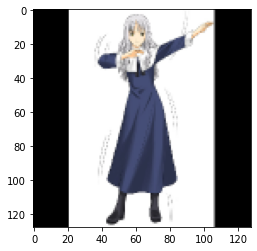

In [ ]:
image = cv2.imread(img_path + '/150.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = pad_images_to_same_size(image,size)


image = cv2.resize(image,(128,128))
plt.imshow(image)

# LOAD DATA

In [ ]:
def load_img_data(path):
  #dat to save
  images = []

  counter = 0
  for each_file in tqdm(os.listdir(path)):
          
      #Get path name of image
      img_path = os.path.join(path, each_file)
      try:
          #Open image then resize
          image = cv2.imread(img_path) # Read as BGR
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          # Append to images list
          images.append(image)

          counter += 1
      except:
          continue

  data = np.array(images, dtype = 'float32')

  del images

  print('---Finish---')
  return data

In [ ]:
#do every shit in one single line else my collab will blow up

train_loader = torch.utils.data.DataLoader(torch.tensor(np.moveaxis(np.load(data_path + 'data.npy')/256,-1,1)).float(), 
                                           batch_size=batch_size, 
                                           num_workers=2, 
                                           shuffle=True,
                                           )
# basically this but in one line

# temp = np.load(f'/content/drive/MyDrive/ganime/{size}.npy')/127.5-1
# temp0 = np.moveaxis(temp,-1,1) 
# del temp
# temp = torch.tensor(temp0).float()
# del temp0
# train_loader = torch.utils.data.DataLoader(temp, 
#                                            batch_size=batch_size, 
#                                            num_workers=2, 
#                                            shuffle=True,
#                                            )


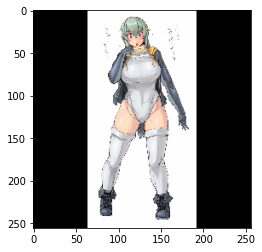

In [ ]:
# plt.imshow(data[0].astype(np.uint8)) # dont forgot to scale (/256 or maybe *256) else .astype(np.uint8)
plt.imshow(data[0])

In [ ]:
def show_images(images) -> None:
    n: int = len(images)
    f = plt.figure(figsize=(200,200))
    for i in range(n):
        # Debug, plot figure
        f.add_subplot(1, n, i + 1)
        plt.imshow(images[i])

    plt.show(block=True)

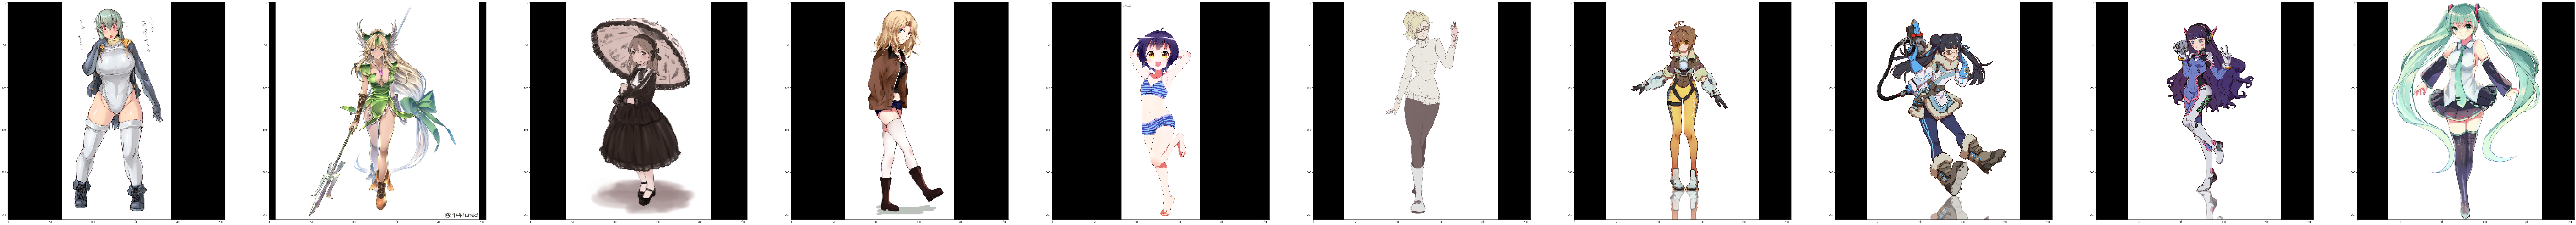

In [ ]:
show_images(data[0:10].astype(np.uint8))

In [ ]:
data.shape

(10039, 256, 256, 3)

# Construct model

## Base-Model

In [ ]:
class Wgenerator(nn.Module):

  def __init__(self, seed_size):

    super(Wgenerator, self).__init__()

    self.conv_transpose_block_1 = nn.Sequential(
        nn.ConvTranspose2d(seed_size, 1024, 4, 1, 0, bias=False),
        nn.BatchNorm2d(1024),
        nn.ReLU()) #shape = (1024,4,4)
    
    self.conv_transpose_block_2 = nn.Sequential(
        nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU()) #shape = (512,8,8)
    
    self.conv_transpose_block_3 = nn.Sequential(
        nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU()) #shape = (256,16,16)

    self.conv_transpose_block_4 = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU()) #shape = (128,32,32)

    self.conv_transpose_block_5 = nn.Sequential(
        nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU()) #shape = (128,32,32)

    self.conv_transpose_block_6 = nn.Sequential(
        nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
        nn.Tanh()) #shape = (3,64,64), outputs are normalized to (-1,1)

  def forward(self, input):
    input = self.conv_transpose_block_1(input)
    input = self.conv_transpose_block_2(input)
    input = self.conv_transpose_block_3(input)
    input = self.conv_transpose_block_4(input)
    input = self.conv_transpose_block_5(input)
    input = self.conv_transpose_block_6(input)
    return input

In [ ]:
class Wdiscriminator(nn.Module):

  def __init__(self, img_channel):

    super(Wdiscriminator, self).__init__()
    self.block = nn.Sequential(

        nn.Conv2d(img_channel, 32, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(32, 64, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(64, 128, 4, 2, 1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(128, 256, 4, 2, 1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(256, 512, 4, 2, 1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),

        nn.Conv2d(512, 1, 4, 1, 0, bias=False),
    )

  def forward(self,input):
    return self.block(input)

## Model Weight Init

In [ ]:
#weight
def weight_init(model):
  std = 0.02
  for layer in model.modules():
    name = layer.__class__.__name__
    if 'Conv' in name: #for all convolution and transpose convolution layers
      #init all weights to have a mean of 0 and std of 0.02
      mean = 0
      nn.init.normal_(layer.weight.data, mean, std)
    elif 'BatchNorm' in name: #for batchnorms, weight and bias refer to the gamma and beta values used in affine transformation
      mean = 1
      nn.init.normal_(layer.weight.data, mean, std)
      nn.init.constant_(layer.bias.data, 0)
    else:
      continue

In [ ]:
#Init the models
seed_size = 256
img_channel = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

gen = Wgenerator(seed_size)
weight_init(gen)

dis = Wdiscriminator(img_channel)
weight_init(dis)

gen.to(device)
dis.to(device)

print(device) #you should get cuda

cuda


In [ ]:
#optimizers 
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(0.5, 0.999))
dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
#Gradient penalty, penaltizes normed gradients that is greater than one to prevent non-linear growth of critic/discriminator's score

def get_gradient(dis, real, fake, epsilon):
  mixed_images = real * epsilon + fake * (1 - epsilon)
  mixed_scores = dis(mixed_images)
  gradient = torch.autograd.grad(
      inputs=mixed_images,
      outputs=mixed_scores,
      grad_outputs=torch.ones_like(mixed_scores), 
      create_graph=True,
      retain_graph=True,
  )[0]
  return gradient

def gradient_penalty(gradient):

  gradient = gradient.view(len(gradient), -1)
  gradient_norm = gradient.norm(2, dim=1)
  penalty = torch.mean((gradient_norm-1)**2)

  return penalty

#custom gen and dis loss, another minimax war rages on
def get_gen_loss(pred):
  return -torch.mean(pred)
  # gen loss is the -mean of the predicted value. this maximizes the pred value of the fake images

def get_dis_loss(fakepred, realpred, penalty, reg_lambda):
  return torch.mean(penalty*reg_lambda - realpred + fakepred)
  # dis loss is the mean of the difference between fake and real. this minimizes the error between the two. gradient penalty is added too

In [ ]:
num_epochs = 300
reg_lambda = 10
visualize_noise = torch.randn(batch_size, seed_size, 1, 1, device=device, dtype=torch.float) #don't touch this noise since we're using it for visualizations

for epoch in range(num_epochs):

  for i, data in enumerate(train_loader):

    b = data.shape[0]

    '''
    First step, we update the discriminator(critic)'s weights
    1. Have the generator generate fake images
    2. Input real images from trainloader
    3. Predict both fake and real images
    4. Compute gradient penalty with random epsilon for random abominations of real and fake images
    5. Compute the loss
    '''
    dis_optimizer.zero_grad()

    #step 1
    noise = torch.randn(b, seed_size, 1, 1, device=device, dtype=torch.float)
    fake_img = gen(noise)

    #step 2
    real_img = data.to(device)   

    #step 3
    fake_dis_pred = dis(fake_img.detach()) #we detach the fake images so that the generator isn't updated
    real_dis_pred = dis(real_img)

    #step 4
    epsilon = torch.rand(len(real_img), 1, 1, 1, device=device, requires_grad=True)
    gradient = get_gradient(dis, real_img, fake_img.detach(), epsilon)
    penalty = gradient_penalty(gradient)

    #step 5
    dis_loss = get_dis_loss(fake_dis_pred, real_dis_pred, penalty, reg_lambda)

    dis_loss.backward()
    dis_optimizer.step()

    '''
    Then, we update the generator's weights
    1. Have the generator generate fake images
    2. Have the trained discriminator predict the fake images
    3. Train the generator with the newly made generator loss function
    '''
    gen_optimizer.zero_grad()

    #step 1 is already done (using "fake_img")

    #step 2
    fake_gen_pred = dis(fake_img)

    #step 3
    gen_loss = get_gen_loss(fake_gen_pred.view(-1))
    gen_loss.backward()
    gen_optimizer.step()

    '''
    Lastly, we visualize
    '''

    dis_loss_show = '{:.4f}'.format(dis_loss.item())
    gen_loss_show = '{:.4f}'.format(gen_loss.item())

    if i%100==0:
      print(f'Iteration {i}\t[Epoch {epoch}/{num_epochs}]\tLosses:\t L_discriminator = {dis_loss_show}\t L_generator = {gen_loss_show}')

  with torch.no_grad():
    if epoch%3 == 0:
      pred = gen(visualize_noise)
      plotter(pred.cpu())
  # Save Path
  torch.save(gen.state_dict(), '/content/drive/MyDrive/ganime/w_gen.pt')
  torch.save(dis.state_dict(), '/content/drive/MyDrive/ganime/w_dis.pt')